# לימוד אופטימייזרים ורגולריזציה בלמידת מכונה

מחברת זו נועדה ללמד את הנושאים **אופטימייזרים** ו**רגולריזציה** בהקשר של למידת מכונה, תוך שימוש בקוד Python המבוסס על PyTorch. המחברת עוקבת אחר קוד נתון, מסבירה כל שלב בו, ומספקת תיאוריה מתמטית מפורטת עם דוגמאות והמחשות.

## מטרות המחברת:
1. הבנת תפקידם של אופטימייזרים באימון מודלים של למידת מכונה, כולל הסבר על SGD, RMSProp ו-Adam.
2. לימוד טכניקות רגולריזציה (L1, L2, Dropout, Early Stopping) ומניעת התאמת יתר.
3. הסבר מפורט של הקוד, כולל כל שלב, תוך קישור לתיאוריה.

## מבנה המחברת:
- **חלק ראשון**: ייבוא חבילות, טעינת נתונים והכנתם.
- **חלק שני**: הסבר על אופטימייזרים, כולל תיאוריה וניתוח הקוד הרלוונטי.
- **חלק שלישי**: הסבר על רגולריזציה, כולל תיאוריה וניתוח הקוד הרלוונטי.
- **חלק רביעי**: סיכום והמלצות.

בואו נתחיל!

## ייבוא חבילות והגדרת פרמטרים

### תיאוריה:
לפני שנצלול לקוד, חשוב להבין את החבילות בהן אנו משתמשים:
- **`torch` ו-`torch.nn`**: ספריית PyTorch ללמידה עמוקה, המספקת כלים לבניית רשתות נוירונים וחישוב גרדיאנטים.
- **`torch.optim`**: מודול המכיל אופטימייזרים כמו SGD, RMSProp ו-Adam.
- **`numpy`**: ספרייה לחישובים מספריים, משמשת ליצירת נתונים.
- **`matplotlib.pyplot`**: כלי ליצירת גרפים וויזואליזציות.
- **`sklearn.preprocessing.StandardScaler`**: כלי לנרמול נתונים, שחשוב לאימון יציב של מודלים.
- **`torch.utils.data`**: כלים לטעינת נתונים באצוות (DataLoader).

הקוד מגדיר גם פרמטרים בסיסיים כמו גודל הדאטה, גודל אצווה, מספר אפוקות וקצב למידה, שישפיעו על האימון.

### קוד:

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

# ---- PARAMETERS ----
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

DataSize = 15000
BATCH_SIZE = 128
EPOCHS = 100
LEARNING_RATE = 0.01

## יצירת נתונים

### תיאוריה:
הקוד יוצר דאטה סינתטי למשימת סיווג בינארי: הנתונים הם נקודות במישור הדו-ממדי (\(x, y\)), והמטרה היא לסווג האם נקודה נמצאת בתוך פוליגון מוגדר או מחוצה לו. זהו דאטה פשוט אך מאתגר מספיק לבחינת אופטימייזרים ורגולריזציה.

### שלבי הקוד:
1. יצירת נקודות אקראיות (\(x_dot, y_dot\)) בגודל `DataSize`.
2. הגדרת פוליגון באמצעות מערך נקודות (\(x_shape, y_shape\)).
3. שימוש ב-`matplotlib.path.Path` כדי לבדוק אילו נקודות נמצאות בתוך הפוליגון (`in_poly`).

### ויזואליזציה:
הקוד מציג גרף של הנקודות, כאשר נקודות בתוך הפוליגון מסומנות בכחול, ומחוצה לו בשחור.

### קוד:

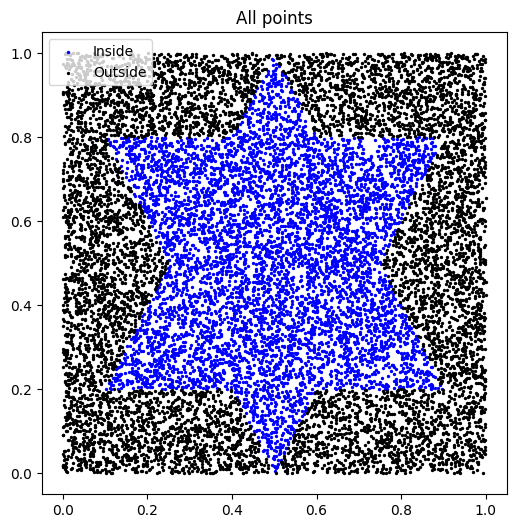

In [2]:
# ---- DATA GENERATION ----
x_dot = np.random.rand(DataSize)
y_dot = np.random.rand(DataSize)
x_shape = np.array([0.5, 0.6, 0.9, 0.75, 0.9, 0.6, 0.5, 0.4, 0.1, 0.25, 0.1, 0.4, 0.5])
y_shape = np.array([1.0, 0.8, 0.8, 0.5, 0.2, 0.2, 0.0, 0.2, 0.2, 0.5, 0.8, 0.8, 1.0])
poly = Path(np.column_stack((x_shape, y_shape)))
points = np.column_stack((x_dot, y_dot))
in_poly = poly.contains_points(points).astype(int)

# ---- PLOT THE DATA ----
plt.figure(figsize=(6,6))
plt.scatter(x_dot[in_poly == 1], y_dot[in_poly == 1], c='b', s=2, label='Inside')
plt.scatter(x_dot[in_poly == 0], y_dot[in_poly == 0], c='k', s=2, label='Outside')
plt.title('All points')
plt.legend()
plt.show()

## חלוקת הנתונים ונרמול

### תיאוריה:
חלוקת הנתונים לחלקי אימון (80%), ולידציה (10%) ובדיקה (10%) היא שיטה סטנדרטית בלמידת מכונה. נרמול הנתונים (באמצעות `StandardScaler`) מבטיח שכל מאפיין יהיה בטווח דומה (ממוצע 0, שונות 1), מה שמסייע לאימון יציב של הרשת.

### שלבי הקוד:
1. חלוקת הנתונים לאינדקסים של אימון, ולידציה ובדיקה.
2. הפרדה של הנקודות (`points`) והתוויות (`in_poly`) לפי האינדקסים.
3. נרמול הנתונים באמצעות `StandardScaler`.

### קוד:

In [3]:
# ---- SPLIT DATA ----
idx_train = np.arange(int(0.8 * DataSize))
idx_val = np.arange(int(0.8 * DataSize), int(0.9 * DataSize))
idx_test = np.arange(int(0.9 * DataSize), DataSize)
X_train, y_train = points[idx_train], in_poly[idx_train]
X_val, y_val     = points[idx_val],   in_poly[idx_val]
X_test, y_test   = points[idx_test],  in_poly[idx_test]

# ---- NORMALIZE DATA ----
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## הגדרת מכשיר וטעינת נתונים

### תיאוריה:
הקוד בודק איזה מכשיר זמין (MPS ל-Mac, CUDA ל-GPU של NVIDIA, או CPU כברירת מחדל) כדי להאיץ את החישובים. בנוסף, הוא משתמש ב-`DataLoader` של PyTorch כדי לארגן את הנתונים באצוות, מה שמאפשר אימון יעיל על כמויות גדולות של נתונים.

### שלבי הקוד:
1. בחירת המכשיר (`device`) לפי זמינות.
2. יצירת פונקציה `get_loader` שממירה נתונים לטנזורים של PyTorch ויוצרת `DataLoader` עם גודל אצווה מוגדר.
3. יצירת `DataLoader` עבור נתוני אימון, ולידציה ובדיקה.

### קוד:

In [4]:
# ---- DEVICE ----
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print("Running on", device)

# ---- DATA LOADERS ----
def get_loader(X, y, shuffle=True):
    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
    return DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=shuffle)

train_loader = get_loader(X_train, y_train, shuffle=True)
val_loader   = get_loader(X_val, y_val, shuffle=False)
test_loader  = get_loader(X_test, y_test, shuffle=False)

Running on mps


## הגדרת הרשת הנוירונית

### תיאוריה:
הרשת הנוירונית היא מודל למידה עמוקה פשוט עם שלוש שכבות מלאות (Fully Connected). היא כוללת אפשרות ל-Dropout, שהוא סוג של רגולריזציה (נדון בהמשך).

### מבנה הרשת:
- **קלט**: 2 מאפיינים (\(x, y\)).
- **שכבה 1**: 2 → 16 נוירונים, פונקציית הפעלה ReLU, Dropout (אופציונלי).
- **שכבה 2**: 16 → 8 נוירונים, ReLU, Dropout (אופציונלי).
- **שכבה 3**: 8 → 1 נוירון, פונקציית Sigmoid (להסתברות בין 0 ל-1).

### קוד:

In [5]:
# ---- NETWORK (with dropout option) ----
class Net(nn.Module):
    def __init__(self, dropout_p=0.0):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.fc(x)

## כלי רגולריזציה

### תיאוריה:
הקוד מגדיר פונקציות לחישוב עונשי L1 ו-L2, שהם סוגי רגולריזציה (נדון בהמשך). עונשים אלה מתווספים לפונקציית ההפסד כדי להגביל את גודל המשקלות של המודל.

### קוד:

In [6]:
# ---- REGULARIZATION UTILS ----
def l1_penalty(model):
    return sum(param.abs().sum() for param in model.parameters() if param.requires_grad)

def l2_penalty(model):
    return sum((param**2).sum() for param in model.parameters() if param.requires_grad)

# אופטימייזרים

## מבוא לאופטימייזרים

### הגדרה:
אופטימייזר הוא אלגוריתם שמטרתו למזער את פונקציית ההפסד (\(L\)) של מודל למידת מכונה על ידי עדכון הפרמטרים (\(\theta\)) שלו. פונקציית ההפסד מודדת את השגיאה בין התחזיות של המודל (\(\hat{y}\)) לערכים האמיתיים (\(y\)). המטרה היא למצוא:

\[
\min_{\theta} L(\theta)
\]

### תהליך האופטימיזציה:
רוב האופטימייזרים מבוססים על **ירידת גרדיאנט** (Gradient Descent), שבה הפרמטרים מעודכנים בכיוון ההפוך לגרדיאנט של פונקציית ההפסד:

\[
\theta \gets \theta - \eta \nabla L(\theta)
\]

כאן, \(\eta\) הוא קצב הלמידה (Learning Rate), ו-\(\nabla L(\theta)\) הוא הגרדיאנט.

### סוגי אופטימייזרים:
הקוד משתמש בשלושה אופטימייזרים:
1. **SGD (Stochastic Gradient Descent)**: גרסה סטוכסטית של ירידת גרדיאנט, שבה הגרדיאנט מחושב על אצוות קטנות.
2. **RMSProp**: משפר את SGD על ידי שימוש בממוצע נע של ריבועי הגרדיאנטים.
3. **Adam**: משלב מומנטום עם RMSProp, נחשב לאחד האופטימייזרים היעילים ביותר.

### אנלוגיה:
חשבו על אופטימייזר כעל מטייל שיורד בהר (פונקציית ההפסד) כדי למצוא את הנקודה הנמוכה ביותר. כל אופטימייזר משתמש באסטרטגיה שונה כדי לנווט ב"שטח".

בואו נצלול לכל אופטימייזר בנפרד!

## אופטימייזר: SGD (Stochastic Gradient Descent)

### תיאוריה:
SGD מעדכן את הפרמטרים על בסיס הגרדיאנט של אצווה קטנה (Mini-Batch) של נתונים, מה שהופך אותו לחסכוני בחישובים בהשוואה לירידת גרדיאנט מלאה. הנוסחה היא:

\[
\theta \gets \theta - \eta \nabla L(\theta; x_i, y_i)
\]

כאן, \(x_i, y_i\) הם דוגמאות מהאצווה, ו-\(\eta\) הוא קצב הלמידה.

### יתרונות:
- פשוט וקל ליישום.
- מתאים לדאטה גדול מאוד.

### חסרונות:
- רגיש לקצב למידה לא מתאים.
- עלול להיתקע בנקודות אוכף או מינימום מקומי.

### שימוש בקוד:
הקוד משתמש ב-SGD עם קצב למידה של 0.01, כפי שמוגדר בפונקציה `train_with_optimizer`.

### קוד:

In [7]:
# ---- TRAIN FUNCTIONS ----
def train_with_optimizer(optimizer_class, label, lr=LEARNING_RATE, epochs=EPOCHS):
    model = Net().to(device)
    optimizer = optimizer_class(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    acc_list = []
    loss_list = []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device).unsqueeze(1)
            optimizer.zero_grad()
            y_pred = model(xb)
            loss = criterion(y_pred, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)
        loss_list.append(epoch_loss / len(train_loader.dataset))
        # Evaluation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device).unsqueeze(1)
                y_pred = model(xb)
                preds = (y_pred > 0.5).float()
                correct += (preds == yb).sum().item()
                total += yb.size(0)
        acc_list.append(correct / total)
    return acc_list, loss_list

## אופטימייזר: RMSProp

### תיאוריה:
RMSProp (Root Mean Square Propagation) משפר את SGD על ידי התאמת קצב הלמידה לכל פרמטר באמצעות ממוצע נע של ריבועי הגרדיאנטים. הנוסחה היא:

\[
E[g^2]_t = \rho E[g^2]_{t-1} + (1-\rho) g_t^2
\]
\[
\theta \gets \theta - \frac{\eta}{\sqrt{E[g^2]_t + \epsilon}} g_t
\]

כאן, \(g_t\) הוא הגרדיאנט, \(\rho\) הוא מקדם דעיכה (בדרך כלל 0.9), ו-\(\epsilon\) הוא קבוע קטן למניעת חלוקה באפס.

### יתרונות:
- מתאים למשטחי הפסד לא-קמורים.
- פחות רגיש לקצב למידה מאשר SGD.

### חסרונות:
- עדיין דורש כוונון של \(\eta\) ו-\(\rho\).

### שימוש בקוד:
RMSProp משמש באותה פונקציית אימון, עם אותו קצב למידה.

## אופטימייזר: Adam

### תיאוריה:
Adam (Adaptive Moment Estimation) משלב מומנטום (ממוצע נע של הגרדיאנטים) עם RMSProp (התאמת קצב למידה). הנוסחאות הן:

\[
m_t = \beta_1 m_{t-1} + (1-\beta_1) g_t
\]
\[
v_t = \beta_2 v_{t-1} + (1-\beta_2) g_t^2
\]
\[
\hat{m}_t = \frac{m_t}{1-\beta_1^t}, \quad \hat{v}_t = \frac{v_t}{1-\beta_2^t}
\]
\[
\theta \gets \theta - \eta \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
\]

כאן, \(m_t\) הוא המומנטום, \(v_t\) הוא הממוצע של ריבועי הגרדיאנטים, \(\beta_1, \beta_2\) הם מקדמי דעיכה (בדרך כלל 0.9 ו-0.999).

### יתרונות:
- יעיל מאוד ברוב המקרים.
- דורש פחות כוונון של קצב הלמידה.

### חסרונות:
- עשוי להתכנס מהר מדי למינימום לא אופטימלי במקרים נדירים.

### שימוש בקוד:
Adam משמש באותה פונקציה, והוא האופטימייזר המרכזי לניסויי הרגולריזציה.

## השוואת אופטימייזרים

### תיאוריה:
הקוד משווה את שלושת האופטימייזרים על ידי אימון המודל עם כל אחד מהם ומדידת הדיוק על קבוצת הבדיקה וההפסד על קבוצת האימון לאורך האפוקות.

### ויזואליזציה:
הגרפים מראים:
1. דיוק הבדיקה לאורך האפוקות.
2. הפסד האימון לאורך האפוקות.

### קוד:

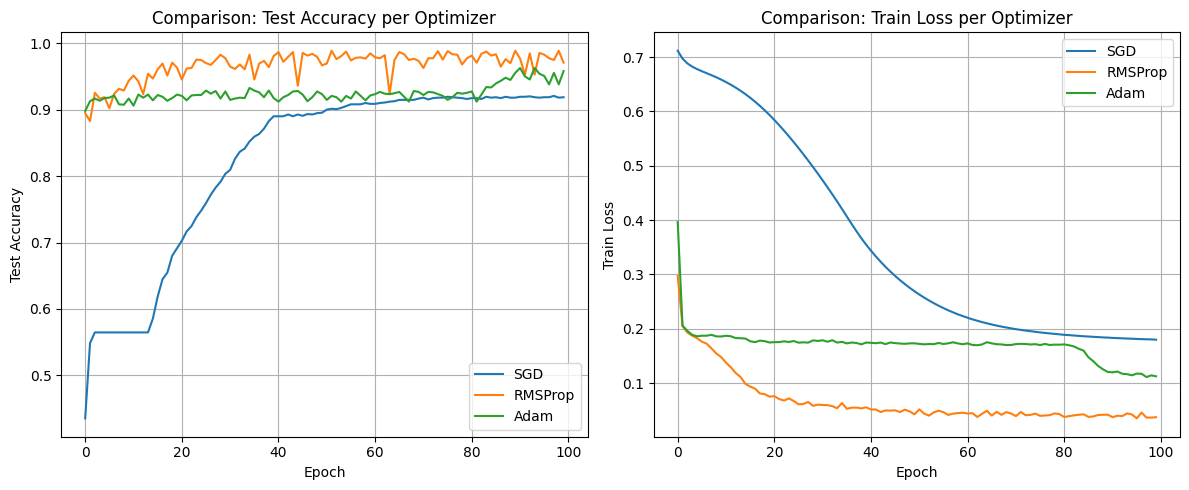

In [8]:
# ---- COMPARISON: Optimizers ----
acc_sgd, loss_sgd   = train_with_optimizer(optim.SGD, "SGD")
acc_rms, loss_rms   = train_with_optimizer(optim.RMSprop, "RMSProp")
acc_adam, loss_adam = train_with_optimizer(optim.Adam, "Adam")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(acc_sgd, label='SGD')
plt.plot(acc_rms, label='RMSProp')
plt.plot(acc_adam, label='Adam')
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("Comparison: Test Accuracy per Optimizer")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(loss_sgd, label='SGD')
plt.plot(loss_rms, label='RMSProp')
plt.plot(loss_adam, label='Adam')
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Comparison: Train Loss per Optimizer")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# רגולריזציה

## מבוא לרגולריזציה

### הגדרה:
רגולריזציה היא טכניקה שמטרתה למנוע **התאמת יתר** (Overfitting), מצב שבו המודל לומד יותר מדי את נתוני האימון ואינו מסוגל להכליל לנתונים חדשים. רגולריזציה מוסיפה עונש לפונקציית ההפסד כדי להגביל את המורכבות של המודל:

$$
L_{\text{reg}} = L + \lambda R(\theta)
$$

כאן, $L$ הוא ההפסד המקורי, $R(\theta)$ הוא עונש הרגולריזציה, ו-$\lambda$ הוא מקדם החוזק.

### סוגי רגולריזציה:
הקוד משתמש בארבע טכניקות:
1. **L1 (Lasso)**: מעודד משקלות קטנים או אפסיים.
2. **L2 (Ridge)**: מעודד משקלות קטנים על ידי הוספת סכום ריבועי המשקלות לפונקציית ההפסד.
3. **Dropout**: מכבה נוירונים באופן אקראי במהלך האימון.
4. **Early Stopping**: מפסיק את האימון כאשר הדיוק על קבוצת הוולידציה מפסיק לעלות.

### אנלוגיה:
רגולריזציה היא כמו להגביל את "חופש" המודל, כדי שלא ילמד יותר מדי פרטים ספציפיים מדי על נתוני האימון.

בואו נצלול לכל טכניקת רגולריזציה בנפרד!

## רגולריזציה: L1 (Lasso)

### תיאוריה:
L1 מוסיף עונש המבוסס על הסכום המוחלט של המשקלות:

$$
R(\theta) = \sum |\theta_i|
$$

הפונקציית ההפסד הופכת ל:

$$
L_{\text{reg}} = L + \lambda \sum |\theta_i|
$$

L1 מעודד **דלילות** (Sparsity), כלומר משקלות רבים הופכים לאפס, מה שמפשט את המודל.

### יתרונות:
- יוצר מודלים דלילים, שקל יותר לפרש.
- שימושי כאשר חלק מהמאפיינים אינם רלוונטיים.

### חסרונות:
- לא חלק, מה שיכול להקשות על האופטימיזציה.

### שימוש בקוד:
L1 מיושם באמצעות הפונקציה `l1_penalty` ומוסף לפונקציית ההפסד במהלך האימון עם $\lambda = 0.001$.

## רגולריזציה: L2 (Ridge)

### תיאוריה:
L2 מוסיף עונש המבוסס על סכום ריבועי המשקלות:

$$
R(\theta) = \sum \theta_i^2
$$

הפונקציית ההפסד הופכת ל:

$$
L_{\text{reg}} = L + \lambda \sum \theta_i^2
$$

L2 מעודד משקלות קטנים, אך לא בהכרח אפסיים, מה שמונע משקלות גדולים מדי.

### יתרונות:
- חלק, מה שמקל על האופטימיזציה.
- מפחית את הרגישות לשינויים קטנים בנתונים.

### חסרונות:
- לא יוצר דלילות כמו L1.

### שימוש בקוד:
L2 מיושם באמצעות `weight_decay` באופטימייזר, עם $\lambda = 0.01$.

## רגולריזציה: Dropout

### תיאוריה:
Dropout מכבה (מכוון לאפס) נוירונים באופן אקראי במהלך האימון, עם הסתברות $p$. זה מונע מהרשת להסתמך יותר מדי על נוירונים ספציפיים.

### יתרונות:
- מפחית התאמת יתר על ידי יצירת "אנסמבל" של רשתות קטנות יותר.
- קל ליישום.

### חסרונות:
- מגדיל את זמן האימון, שכן הרשת משתנה בכל איטרציה.

### שימוש בקוד:
Dropout מיושם בשכבות הרשת עם $p=0.5$.

## רגולריזציה: Early Stopping

### תיאוריה:
Early Stopping עוצר את האימון כאשר הדיוק על קבוצת הוולידציה מפסיק לעלות לאחר מספר אפוקות מוגדר (Patience). זה מונע התאמת יתר על ידי בחירת המודל בנקודה שבה הוא הכי כללי.

### יתרונות:
- פשוט ויעיל.
- לא דורש שינוי של פונקציית ההפסד.

### חסרונות:
- דורש קבוצת ולידציה נפרדת.
- עלול לעצור מוקדם מדי.

### שימוש בקוד:
Early Stopping מיושם עם `patience=7`, והמודל הטוב ביותר נשמר.

## אימון עם רגולריזציה

### תיאוריה:
הקוד מאמן את המודל עם טכניקות רגולריזציה שונות ומשווה את הדיוק וההפסד על קבוצת הוולידציה.

### קוד:

Early Stopping: Early stopping at epoch 13


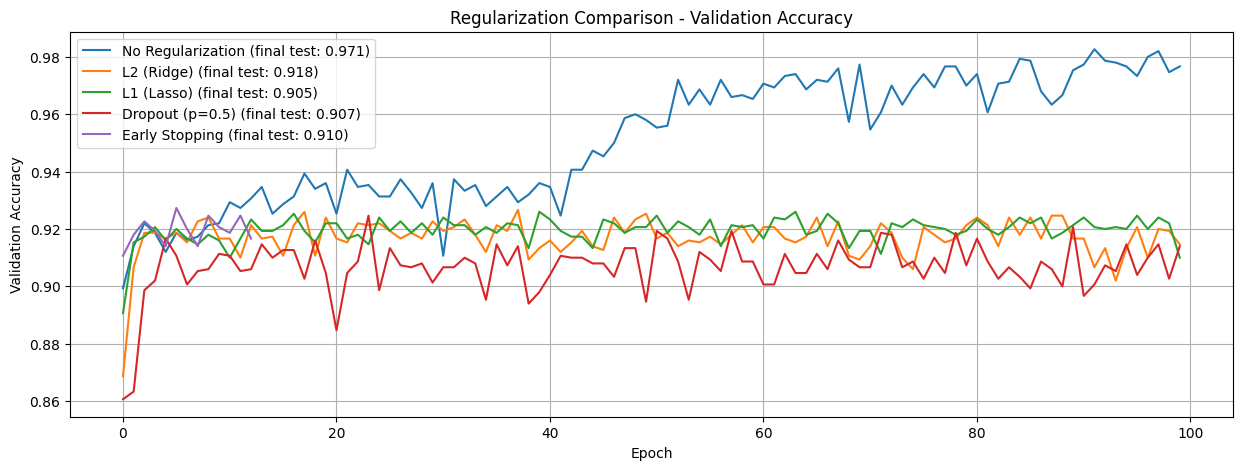

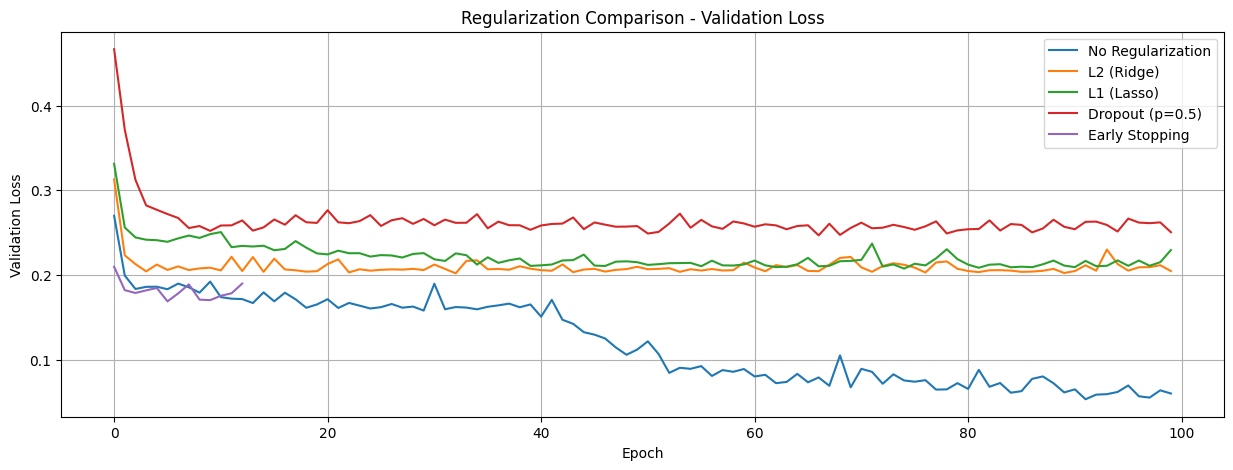


==== Final Test Accuracies ====
No Regularization   : 0.9707
L2 (Ridge)          : 0.9180
L1 (Lasso)          : 0.9053
Dropout (p=0.5)     : 0.9067
Early Stopping      : 0.9100


In [9]:
def train_with_regularization(optimizer_class, label, 
                             l1_lambda=0.0, l2_lambda=0.0, 
                             dropout_p=0.0, 
                             early_stopping=False, 
                             patience=10,
                             lr=LEARNING_RATE, epochs=EPOCHS):
    model = Net(dropout_p=dropout_p).to(device)
    optimizer = optimizer_class(model.parameters(), lr=lr, weight_decay=l2_lambda)
    criterion = nn.BCELoss()
    acc_list = []
    loss_list = []
    val_acc_list = []
    val_loss_list = []
    best_val_acc = 0
    patience_counter = 0
    best_state = None

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device).unsqueeze(1)
            optimizer.zero_grad()
            y_pred = model(xb)
            loss = criterion(y_pred, yb)
            # add L1 penalty manually (L2 via weight_decay)
            if l1_lambda > 0:
                loss += l1_lambda * l1_penalty(model)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)
        loss_list.append(epoch_loss / len(train_loader.dataset))

        # Evaluate on validation
        model.eval()
        correct = 0
        total = 0
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device).unsqueeze(1)
                y_pred = model(xb)
                loss = criterion(y_pred, yb)
                if l1_lambda > 0:
                    loss += l1_lambda * l1_penalty(model)
                val_loss += loss.item() * xb.size(0)
                preds = (y_pred > 0.5).float()
                correct += (preds == yb).sum().item()
                total += yb.size(0)
        val_acc = correct / total
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss / total)

        # Early stopping
        if early_stopping:
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_state = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"{label}: Early stopping at epoch {epoch+1}")
                    break

    # Evaluate on test with best model (early stopping)
    if early_stopping and best_state is not None:
        model.load_state_dict(best_state)

    test_correct = 0
    test_total = 0
    model.eval()
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device).unsqueeze(1)
            y_pred = model(xb)
            preds = (y_pred > 0.5).float()
            test_correct += (preds == yb).sum().item()
            test_total += yb.size(0)
    test_acc = test_correct / test_total

    return {
        "acc": val_acc_list,
        "loss": val_loss_list,
        "final_test_acc": test_acc,
        "label": label
    }

# ---- COMPARISON: Regularization ----
optim_class = optim.Adam
results = []

# 1. No regularization (baseline)
results.append(
    train_with_regularization(optim_class, "No Regularization")
)

# 2. L2 Regularization (Ridge)
results.append(
    train_with_regularization(optim_class, "L2 (Ridge)", l2_lambda=0.01)
)

# 3. L1 Regularization (Lasso)
results.append(
    train_with_regularization(optim_class, "L1 (Lasso)", l1_lambda=0.001)
)

# 4. Dropout Regularization
results.append(
    train_with_regularization(optim_class, "Dropout (p=0.5)", dropout_p=0.5)
)

# 5. Early Stopping (on baseline)
results.append(
    train_with_regularization(optim_class, "Early Stopping", early_stopping=True, patience=7)
)

plt.figure(figsize=(15,5))
for r in results:
    plt.plot(r["acc"], label=f'{r["label"]} (final test: {r["final_test_acc"]:.3f})')
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Regularization Comparison - Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(15,5))
for r in results:
    plt.plot(r["loss"], label=r["label"])
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Regularization Comparison - Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

print("\n==== Final Test Accuracies ====")
for r in results:
    print(f'{r["label"]:20s}: {r["final_test_acc"]:.4f}')

# סיכום

## מה למדנו:
- **אופטימייזרים**: SGD, RMSProp ו-Adam הם אלגוריתמים שונים למזעור פונקציית ההפסד. Adam נוטה להיות היעיל ביותר ברוב המקרים, אך SGD ו-RMSProp יכולים להיות שימושיים במקרים מסוימים.
- **רגולריזציה**: L1, L2, Dropout ו-Early Stopping מסייעים למנוע התאמת יתר על ידי הגבלת מורכבות המודל. כל טכניקה מתאימה למצבים שונים, וחשוב לבחור בהתאם למשימה.

## המלצות מעשיות:
- התחילו עם Adam כברירת מחדל, אך נסו SGD עם מומנטום או RMSProp אם התוצאות אינן משביעות רצון.
- השתמשו ב-L2 או Dropout כטכניקות רגולריזציה ראשוניות, והוסיפו Early Stopping כדי לחסוך בזמן אימון.
- נסו לשנות את קצב הלמידה ($\eta$) או את מקדמי הרגולריזציה ($\lambda$) כדי לראות את ההשפעה על הביצועים.

## התנסות נוספת:
שנו את הפרמטרים בקוד (למשל, $\lambda$ של L1/L2, $p$ של Dropout, או Patience של Early Stopping) והשוו את התוצאות. זה יעזור לכם להבין לעומק את ההשפעה של כל טכניקה.